In [186]:
import clickhouse_connect
clickhouse_client = clickhouse_connect.get_client(host='localhost')

In [187]:
query = f"""
    SELECT *
    FROM wgn
    WHERE Direction = 0
    ORDER BY TsTaiNs
"""
df_wgn =  clickhouse_client.query_df(query)
print(df_wgn)

                                 TestId             TsTaiNs  AdjDistanceDb  \
0      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:25            0.0   
1      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:26            0.0   
2      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:27            0.0   
3      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:28            0.0   
4      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:29            0.0   
...                                 ...                 ...            ...   
34045  bd702809ed754c949fbdc822cb90309f 2025-04-27 18:09:32           25.0   
34046  bd702809ed754c949fbdc822cb90309f 2025-04-27 18:09:33           25.0   
34047  bd702809ed754c949fbdc822cb90309f 2025-04-27 18:09:34           25.0   
34048  bd702809ed754c949fbdc822cb90309f 2025-04-27 18:09:35           25.0   
34049  bd702809ed754c949fbdc822cb90309f 2025-04-27 18:09:36           25.0   

       NoiseLevelDb  Direction  TargetThroughputMbps  Throughpu

In [188]:
df_wgn['NoiseChangedCounter'] = 0
df_wgn['NoiseChangedCounter'] = (df_wgn['NoiseLevelDb'] != df_wgn['NoiseLevelDb'].shift()).cumsum() - 1
print(df_wgn)

                                 TestId             TsTaiNs  AdjDistanceDb  \
0      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:25            0.0   
1      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:26            0.0   
2      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:27            0.0   
3      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:28            0.0   
4      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:29            0.0   
...                                 ...                 ...            ...   
34045  bd702809ed754c949fbdc822cb90309f 2025-04-27 18:09:32           25.0   
34046  bd702809ed754c949fbdc822cb90309f 2025-04-27 18:09:33           25.0   
34047  bd702809ed754c949fbdc822cb90309f 2025-04-27 18:09:34           25.0   
34048  bd702809ed754c949fbdc822cb90309f 2025-04-27 18:09:35           25.0   
34049  bd702809ed754c949fbdc822cb90309f 2025-04-27 18:09:36           25.0   

       NoiseLevelDb  Direction  TargetThroughputMbps  Throughpu

In [189]:
import heapq
def moving_average(arr, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(arr, weights, mode='valid')

def get_throughput(series):
    W = 10
    arr = series.to_numpy()
    mv_avg = moving_average(arr, W)
    largest_numbers = heapq.nlargest(W, mv_avg)
    return sum(largest_numbers) / W

     AdjDistanceDb  NoiseLevelDb  NoiseChangedCounter           BeginTime  \
44             0.0         -37.5                   15 2025-04-26 15:52:17   
59             0.0         -30.0                    7 2025-04-26 13:26:43   
65            20.0        -100.0                   85 2025-04-27 15:00:22   
102           30.0         -44.0                   76 2025-04-27 12:35:04   

                EndTime  TargetThroughputMbps  MaxThroughputMbps  
44  2025-04-26 16:03:43             19.615385          33.867853  
59  2025-04-26 14:12:30             18.357143          14.129158  
65  2025-04-27 15:04:14              5.166667          16.252905  
102 2025-04-27 12:36:14              0.500000           1.121100  
    AdjDistanceDb  NoiseLevelDb  NoiseChangedCounter           BeginTime  \
0             0.0        -100.0                    0 2025-04-26 12:33:25   
1             0.0         -90.0                    1 2025-04-26 12:41:01   
2             0.0         -80.0                    

/tmp/ipykernel_95/430687942.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


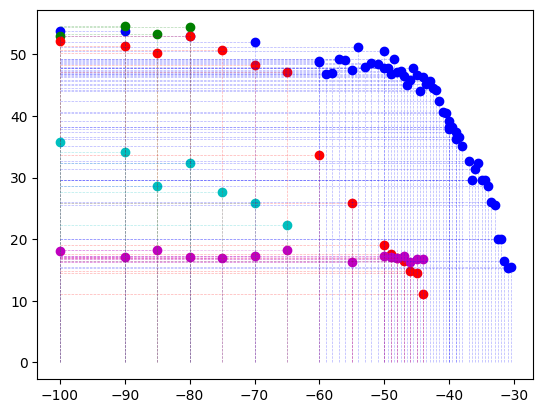

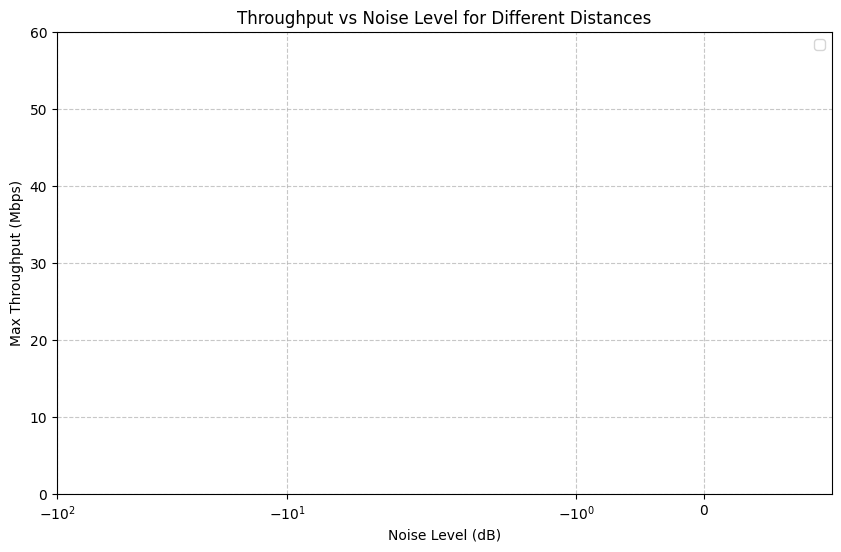

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df_dataset_valid = df_wgn.groupby(['AdjDistanceDb', 'NoiseLevelDb', 'NoiseChangedCounter']).agg(
    BeginTime=('TsTaiNs', 'min'),
    EndTime=('TsTaiNs', 'max'),
    TargetThroughputMbps=('TargetThroughputMbps', 'mean'),
    MaxThroughputMbps=('ThroughputMbps', get_throughput),
).reset_index()

df_dataset_invalid = df_dataset_valid[~np.isclose(df_dataset_valid['TargetThroughputMbps'], 23.090909, rtol=1e-5)]
print(df_dataset_invalid)

df_dataset_valid = df_dataset_valid[np.isclose(df_dataset_valid['TargetThroughputMbps'], 23.090909, rtol=1e-5)]
df_dataset_valid = df_dataset_valid.sort_values('BeginTime').reset_index(drop=True)
print(df_dataset_valid)

unique_distances = np.sort(df_dataset_valid['AdjDistanceDb'].unique())

plt.figure(figsize=(10, 6))
for i, distance in enumerate(unique_distances):
    distance_data = df_dataset_valid[df_dataset_valid['AdjDistanceDb'] == distance]
    color = colors[i % len(colors)]
    
    plt.scatter(distance_data['NoiseLevelDb'], distance_data['MaxThroughputMbps'], 
                color=color, label=f'Distance = {distance}')

    for x, y in zip(distance_data['NoiseLevelDb'], distance_data['MaxThroughputMbps']):
        plt.plot([x, x], [0, y], f'{color}--', linewidth=0.5, alpha=0.3)
        plt.plot([-100, x], [y, y], f'{color}--', linewidth=0.5, alpha=0.3)


colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
plt.xlabel('Noise Level (dB)')
plt.ylabel('Max Throughput (Mbps)')
plt.title('Throughput vs Noise Level for Different Distances')
plt.xscale('symlog')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.xticks([-100, -90, -80, -70, -60, -50, -40, -30])
plt.ylim(0, 60)
plt.xscale('symlog')
plt.legend()
plt.show()

# for distance in unique_distances:
#     plt.figure(figsize=(10, 6))
#     distance_data = df_dataset_valid[df_dataset_valid['AdjDistanceDb'] == distance]

#     plt.scatter(distance_data['NoiseLevelDb'], distance_data['MaxThroughputMbps'])

#     for x, y in zip(distance_data['NoiseLevelDb'], distance_data['MaxThroughputMbps']):
#         plt.plot([x, x], [0, y], 'k--', linewidth=0.5)
#         plt.plot([-100, x], [y, y], 'k--', linewidth=0.5)

#     plt.xlabel('Noise Level (dB)')
#     plt.ylabel('Max Throughput (Mbps)')
#     plt.title(f'AdjDistanceDb = {distance}')
#     plt.xscale('symlog')
#     plt.grid(True, which='both', linestyle='--', alpha=0.7)
#     plt.xticks([-100, -90, -80, -70, -60, -50, -40, -30])
#     plt.ylim(0, 60)
#     plt.show()